In [25]:
from langchain_core.runnables import RunnableConfig
from langchain.schema import AIMessage
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from fpdf import FPDF
import os
import requests
import random
import pdfplumber
import warnings
import dotenv

warnings.filterwarnings("ignore")
dotenv.load_dotenv()

True

In [26]:
class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "Tool Call Result"]

In [27]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [28]:
@tool
def read_pdf(file_path: str) -> str:
    """
    PDF 파일에서 텍스트를 추출하는 도구입니다.
    표 형식 또는 일반 텍스트가 포함된 PDF를 읽고 문자열로 반환합니다.
    
    file_path 예시: './reports/report.pdf'
    """
    try:
        text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text.strip() if text.strip() else "❌ PDF에서 텍스트를 추출할 수 없습니다."
    except Exception as e:
        return f"❌ PDF 읽기 오류: {str(e)}"

In [29]:
@tool
def write_pdf(content: str, filename: str = "output.pdf", summary: bool =True):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """

    if summary:
        prompt = PromptTemplate.from_template("""
                당신은 보고서를 작성하는 어시스턴트입니다. 당신에겐 문서 모음이 제공되고 이를 잘 분석하여 보고서를 작성하여야 합니다.
                아래의 content는 문서 모음입니다. 문서의 제목, 본문을 잘 판단하고 정리하여 요약합니다.
                항상 구조화된 출력을 제공하세요.
                항상 마지막엔 인사이트도 첨부합니다.

                content : {content}
                """)

        chain = prompt | llm

        content = chain.invoke({"content":content}).content

    else:
        pass

    font_url = "https://github.com/google/fonts/raw/main/ofl/notosanskr/NotoSansKR%5Bwght%5D.ttf"
    font_path = "./fonts/NotoSansKR.ttf"

    try:
        os.mkdir("./fonts/")
        response = requests.get(font_url)
        with open(font_path, "wb") as f:
            f.write(response.content)
    except:
        pass

    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "./fonts/NotoSansKR.ttf"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("NotoSans", "", font_path, uni=True)
        pdf.set_font("NotoSans", size=12)
    except:
        raise ValueError("한글 폰트를 등록할 수 없습니다.")

    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./reports/{filename}")

    return f"./reports/{filename} 저장 완료"

In [30]:
tools = [TavilySearchResults(include_domains=["naver.com", "google.com"]), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(root_dir="./reports/",
                                                                            selected_tools=["file_delete","list_directory", ]).get_tools()]
search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [31]:
try:
    os.mkdir("./reports/")
except:
    pass

In [32]:
# PDF 쓰기 도구 예시

write_tool.invoke({"content":"안녕하세요? \n세미나에 참석해주셔서 감사합니다.", "filename":"Write_pdf_test.pdf", "summary":False})

'./reports/Write_pdf_test.pdf 저장 완료'

In [33]:
# PDF 읽기 도구 예시

print("\n\n", read_tool.invoke("./reports/Write_pdf_test.pdf"))



 안녕하세요?
세미나에 참석해주셔서 감사합니다.


In [34]:
# 파일 목록 도구 예시

print(listdir_tool.invoke(""))

Write_pdf_test.pdf


In [35]:
# 삭제 도구 예시

delete_tool.invoke("Write_pdf_test.pdf")

'File deleted successfully: Write_pdf_test.pdf.'

In [36]:
llm_with_tools = llm.bind_tools(tools)

In [37]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [38]:
history_checker = llm.with_structured_output(HistoryChecker)

In [39]:
def shorterm_memory(state:State):

    if len(state["messages"]) > 6:
        history = state["messages"][-6:-1]
    elif len(state["messages"]) == 1:
        history = ""
    else:
        history = state["messages"][:-1]

    return history

In [40]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | history_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                            "query":state["query"]})

    return result.yes_no

In [41]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    
    chain = prompt | llm

    history = shorterm_memory(state)

    answer = chain.invoke({"history":history,
                           "query":state["query"]})
    
    if len(state["tool_call"]) == 0:
        return {"answer":answer.content,
                "messages":answer,
                "tool_call":"사용된 기록 없음."}
    else:
        return {"answer":answer.content,
                "messages":answer}

In [42]:
def history_node(state:State):
    if len(state["messages"]) == 1:
        return {"answer":"답변 없음",
                "tool_call":"사용된 도구 없음"}
    else:
        return state

In [43]:
def select(
    state: State,
):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                최근에 사용한 도구가 있다면 도구도 참고하세요. 다른 도구를 사용하는 것이 더 좋은 방법이 될 수 있습니다.
                                                    
                대화 기록 : {history}     
                                          
                최근 사용한 도구 : {tool_name}
                                        
                정답 : {answer}
                                        
                질문 : {query}
                                          
                """)

    chain = prompt | llm_with_tools

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                           "tool_name" : state["tool_call"],
                            "answer": state["answer"],
                            "query": state["query"]})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls
        return {"messages": result,
                "tool_call": [result]}
    else:
        return {"messages":AIMessage(content=f"""도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
                                        """),
                                    "tool_call":None}

    

In [44]:
tool_node = ToolNode(tools)

In [45]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.
    
    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """


    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")    

In [46]:
answer_checker = llm.with_structured_output(AnswerChecker)

In [47]:
def answer_check(state:State):

    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기 어시스턴트입니다.
    
    정답이 질문을 해결할 수 있는지 여부를 판단합니다.
    질문을 해결할 수 없다면 도구를 이용합니다.

    질문을 해결할 수 있다면 "end", 아니라면 "tool"을 반환합니다.
                                          
    기존 History도 참고하여 답변하세요.
                                          
    History : {history}
                            
    정답 : {answer}
                            
    질문 : {query}
    """)

    chain = prompt | answer_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                            "answer": state["answer"],
                            "query": state["query"]})
    
    return result.end

In [48]:
def response(state:State):

    return {"answer":state["messages"][-1]}

In [49]:
graph_builder = StateGraph(State)

In [50]:
graph_builder.add_node("history_node", history_node)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "response")
graph_builder.add_edge("memory_chat", "response")
graph_builder.add_conditional_edges("response",
                                    answer_check,
                                    {"end":END,
                                    "tool":"select"});

In [51]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [52]:
def reset_config(limit=15):

    thread_id=random.randint(1,999999)

    config = RunnableConfig(recursion_limit=limit, configurable={"thread_id": thread_id})

    return config

In [53]:
config = reset_config()

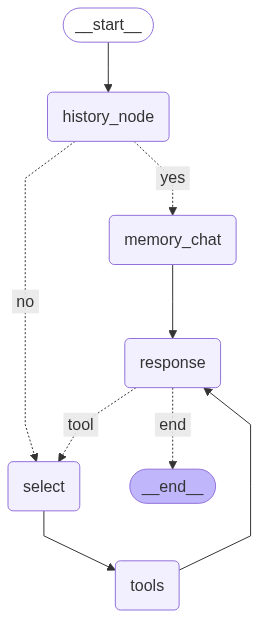

In [54]:
graph

In [55]:
# 출력 함수 정의
# mode = "values" : 상태의 키, 값의 형태로 반환
# mode = "updates" : 업데이트되는 값만 반환

def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query),
                           "query":query}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

In [56]:
config = reset_config()

query = "1+1은 뭔가요?"

streaming(query, config, mode="updates")



=== history_node ===


{'answer': '답변 없음', 'tool_call': '사용된 도구 없음'}


=== memory_chat ===


{'answer': '1+1은 2입니다.', 'messages': AIMessage(content='1+1은 2입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 78, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run-fa912bdd-1f19-44ae-9d6a-b797d906a908-0', usage_metadata={'input_tokens': 78, 'output_tokens': 8, 'total_tokens': 86, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


=== response ===


{'answer': AIMessage(content='1+1은 2입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': 

In [62]:
config = reset_config()

query = "피엔티라는 회사에 대해 조사해서 보고서의 형태로 정리해주세요. 그 후에 '피엔티_기업_보고서.pdf'라는 이름의 PDF파일로 저장해주세요."

streaming(query, config)

================================ Human Message =================================

피엔티라는 회사에 대해 조사해서 보고서의 형태로 정리해주세요. 그 후에 '피엔티_기업_보고서.pdf'라는 이름의 PDF파일로 저장해주세요.
================================ Human Message =================================

피엔티라는 회사에 대해 조사해서 보고서의 형태로 정리해주세요. 그 후에 '피엔티_기업_보고서.pdf'라는 이름의 PDF파일로 저장해주세요.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kqedtxJwuGDw8glFmdYjq5Zp)
 Call ID: call_kqedtxJwuGDw8glFmdYjq5Zp
  Args:
    query: 피엔티 회사
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "피엔티 주가 전망 : 실적 배당금", "url": "https://blog.naver.com/future-rich/223448064438?viewType=pc", "content": "피엔티는 2차 전지 장비 관련주입니다. ​. 2003년에 설립된 회사로 Roll to Roll 기술을 바탕으로 IT 용 소재, 2차 전지의 음극 및 분리 막 소재,", "score": 0.7634314}, {"title": "피엔티의 사업분석 및 고객사에 대하여", "url": "https://blog.naver.com/humanindicator/222353810766", "content": "피엔티는 2차전

In [63]:
query = "피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요. 파일 이름은 '피엔티_경쟁사_보고서.pdf'로 저장합니다."

streaming(query, config)

================================ Human Message =================================

피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요. 파일 이름은 '피엔티_경쟁사_보고서.pdf'로 저장합니다.
================================ Human Message =================================

피엔티의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요. 파일 이름은 '피엔티_경쟁사_보고서.pdf'로 저장합니다.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_uvoLad3MqaQwYSArFX2rZfGG)
 Call ID: call_uvoLad3MqaQwYSArFX2rZfGG
  Args:
    query: 피엔티 경쟁사
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "피엔티의 사업분석 및 고객사에 대하여", "url": "https://blog.naver.com/humanindicator/222353810766", "content": "피엔티의 경쟁사는 롤투롤 장비회사의 양대 산맥인 '씨아이에스'다. 주 거래처는 LG이며 최근 노스볼트의 전극공정까지 수주를 따낸 핫한 기업이다. 둘다", "score": 0.8849276}, {"title": "2차전지 장비주 피엔티의 경쟁사 히라노(Hirano)의 실적발표와 ...", "url": "https://m.blog.naver.com/PostView.naver?blogId=km_joshua&logNo=222055617066", "content": 

In [64]:
config = reset_config()

query = "현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘"

streaming(query, config)

================================ Human Message =================================

현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘
================================ Human Message =================================

현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘
================================== Ai Message ==================================
Tool Calls:
  list_directory (call_F1m7djfBKcT0AGZVxgkc9yU1)
 Call ID: call_F1m7djfBKcT0AGZVxgkc9yU1
  Args:
================================= Tool Message =================================
Name: list_directory

피엔티_기업_보고서.pdf
피엔티_경쟁사_보고서.pdf
================================= Tool Message =================================
Name: list_directory

피엔티_기업_보고서.pdf
피엔티_경쟁사_보고서.pdf
================================== Ai Message ==================================
Tool Calls:
  file_delete (call_EEjC5oBNcELdQVrq4f2BXRRo)
 Call ID: call_EEjC5oBNcELdQVrq4f2BXRRo
  Args:
    file_path: 피엔티_기업_보고서.pdf
  file_delete (call_8LtXXmUmWnxoriZG6Uq5kKXr)
 Call ID: call_8LtXXmUmWnxoriZG6Uq5kKXr
  Args:
    file_pa

In [65]:
config = reset_config()

streaming("""
          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
          """, config)

================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
          
================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
          
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_mA1CprX33OkIGsKkRJgCb8ET)
 Call ID: call_mA1CprX33OkIGsKkRJgCb8ET
  Args:
    query: 모두의연구소
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "집단지성의 힘으로 스스로 연구하고 나누는 곳 <모두 ...", "url": "https://blog.naver.com/kmacforever/222695255714", "content": "모두의연구소는 AI 기술과 같은 새로운 지식에 갈증을 느끼는 사람이면 학력이나 나이 제한 없이 누구나 참여해 배운 걸 공유하면서 함께 성장하는 곳이다", "score": 0.82761955}, 

In [66]:
config = reset_config()

query = "'모두의연구소_레포트.pdf'라는 파일 삭제해줘"

streaming(query, config)

================================ Human Message =================================

'모두의연구소_레포트.pdf'라는 파일 삭제해줘
================================ Human Message =================================

'모두의연구소_레포트.pdf'라는 파일 삭제해줘
================================== Ai Message ==================================
Tool Calls:
  file_delete (call_wNWMGiTwY6sg9ZmwGYMjgZuy)
 Call ID: call_wNWMGiTwY6sg9ZmwGYMjgZuy
  Args:
    file_path: ./모두의연구소_레포트.pdf
================================= Tool Message =================================
Name: file_delete

File deleted successfully: ./모두의연구소_레포트.pdf.
================================= Tool Message =================================
Name: file_delete

File deleted successfully: ./모두의연구소_레포트.pdf.
